In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from tqdm.auto import tqdm
import sys

/Users/pnr5sh/miniconda3/envs/astro2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sys.path.append("/Users/pnr5sh/Documents/phd/mmmp/")
import sidchaini.sidhelpers as sidhelpers

In [5]:
#reading in meta data from sid's dir
header = ['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC', 'Obj. Type',
          'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)', 'From', 'Telescope',
          'Instrument', 'Observer/s', 'Reducer/s', 'Source group', 'Public', 'Associated groups',
          'End prop. period', 'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
          'Extinction-Corrected', 'WL Medium','WL Units', 'Flux Unit Coefficient', 'Spec. units',
          'Flux Calibrated By', 'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
          'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib', 'Publish', 'Remarks',
          'Created by', 'Creation date']
all_spec_meta = pd.read_csv('../sidchaini/1. download ALL wise data/wiserep_spectra_combined.csv', header='infer')# names=header, delimiter=', ', skiprows=1)
all_spec_meta.columns

Index(['wise_objid', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC',
       'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'Phase (days)',
       'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s',
       'Source group', 'Public', 'Associated groups', 'End prop. period',
       'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality',
       'Extinction-Corrected', 'WL Medium', 'WL Units',
       'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By',
       'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism',
       'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib',
       'Publish', 'Remarks', 'Created by', 'Creation date'],
      dtype='object')

In [6]:
#unique objs in all wiserep spec
all_spec_meta['Obj. Type'].unique()

array(['SN Ia', 'SN II', 'SN Ib', 'SN IIn', 'SN Ib/c', 'Other', 'M dwarf',
       'SN Ic-BL', 'SN IIP', 'SLSN-R', 'SN I-rapid', 'Varstar', 'Galaxy',
       'SLSN-I', 'SN Ic', 'SN IIL', 'SN Ia-pec', 'CV', 'SN Ia-91T-like',
       'SN IIb', 'LBV', 'SN IIn-pec', nan, 'WR-WN', 'SN Ia-CSM',
       'SN Ia-91bg-like', 'SN II-pec', 'SN', 'SN Iax[02cx-like]',
       'SN Ic-Ca-rich', 'TDE', 'SN Ibn', 'Gap', 'AGN', 'SN Ib-pec',
       'SLSN-II', 'SN I', 'ILRT', 'Nova', 'Impostor-SN', 'Computed-PISN',
       'WR-WC', 'Computed-IIP', 'Std-spec', 'TDE-He', 'SN Ia-Ca-rich',
       'Computed-Ia', 'SN Ib-Ca-rich', 'SN Ic-pec', 'SN Ia-SC',
       'SN Ib/c-Ca-rich', 'LRN', 'Computed-IIb', 'Afterglow', 'QSO',
       'Kilonova', 'SN Icn', 'Computed-IIn', 'Light-Echo', 'FBOT',
       'SN Ien', 'SN Ibn/Icn', 'FRB', 'TDE-H-He', 'Blazar', 'NA/Unknown'],
      dtype=object)

In [7]:
# filters for specific types
multi_types = (all_spec_meta['Obj. Type']=='SN IIb')|(all_spec_meta['Obj. Type']=='SN Ib')|(all_spec_meta['Obj. Type']=='SN Ic')|(all_spec_meta['Obj. Type']=='SLSN-I')|(all_spec_meta['Obj. Type']=='SLSN-II')|(all_spec_meta['Obj. Type']=='SN IIn')

#filters for ZTF/P60 data
p60 = (all_spec_meta['Telescope']=='P60')
sedm = (all_spec_meta['Instrument']=='SEDM')

In [8]:
# creating df of only objects meeting our target types, from ZTF 
mp_spec_df = all_spec_meta.loc[multi_types&p60&sedm]
print(len(mp_spec_df['IAU name'].unique()))

#converting redshifts to floats
pd.to_numeric(mp_spec_df['Redshift'], errors='coerce')

#defining specific type filters
# iib = (mp_spec_df['Obj. Type']=='SN IIb')
# ib = (mp_spec_df['Obj. Type']=='SN Ib')
# ic = (mp_spec_df['Obj. Type']=='SN Ic')
# slsni = (mp_spec_df['Obj. Type']=='SLSN-I')
# slsnii = (mp_spec_df['Obj. Type']=='SLSN-II')
# iin = (mp_spec_df['Obj. Type']=='SN IIn')

iib = (all_spec_meta['Obj. Type']=='SN IIb')
ib = (all_spec_meta['Obj. Type']=='SN Ib')
ic = (all_spec_meta['Obj. Type']=='SN Ic')
slsni = (all_spec_meta['Obj. Type']=='SLSN-I')
slsnii = (all_spec_meta['Obj. Type']=='SLSN-II')
iin = (all_spec_meta['Obj. Type']=='SN IIn')

212


In [9]:
# all_spectra = []
# flux_counter = 0
# readerror_counter = 0
# errs = []
# metadata = []

# # Define a common wavelength grid - we'll determine this dynamically
# min_global_lambda = float('inf')
# max_global_lambda = 0
# typical_delta = []

# # First pass - determine global wavelength range and typical resolution
# for fn, wl_unit, spec_unit, flux_ucoeff, lambda_min, lambda_max, del_lambda in tqdm(
#     zip(
#         all_spec_meta["Ascii file"],
#         all_spec_meta["WL Units"],
#         all_spec_meta["Spec. units"],
#         all_spec_meta["Flux Unit Coefficient"],
#         all_spec_meta["Lambda-min"],
#         all_spec_meta["Lambda-max"],
#         all_spec_meta["Del-Lambda"],
#     ),
#     total=len(all_spec_meta),
# ):
#     if lambda_min and lambda_max and lambda_min < lambda_max:
#         min_global_lambda = min(min_global_lambda, lambda_min)
#         max_global_lambda = max(max_global_lambda, lambda_max)
#     if del_lambda and del_lambda > 0:
#         typical_delta.append(del_lambda)

# # Set up common wavelength grid
# delta_lambda = np.median(typical_delta) if typical_delta else 1.0  # Default if no valid delta
# common_wavelengths = np.arange(min_global_lambda, max_global_lambda, delta_lambda)

In [10]:
# # Second pass - read and interpolate spectra to common grid
# for fn, wl_unit, spec_unit, flux_ucoeff, lambda_min, lambda_max, del_lambda in tqdm(
#     zip(
#         all_spec_meta["Ascii file"],
#         all_spec_meta["WL Units"],
#         all_spec_meta["Spec. units"],
#         all_spec_meta["Flux Unit Coefficient"],
#         all_spec_meta["Lambda-min"],
#         all_spec_meta["Lambda-max"],
#         all_spec_meta["Del-Lambda"],
#     ),
#     total=len(all_spec_meta),
# ):
#     try:
#         df = sidhelpers.read_spectra(
#             f"./adrian/iib_spectra/spectra/{fn}"
#         )
        
#         # Extract wavelength and flux columns (assuming standard naming)        
#         wavelengths = df.to_numpy()[:, 0]
#         flux = df.to_numpy()[:, 1]
        
#         # Check for valid data
#         valid_mask = ~np.isnan(wavelengths) & ~np.isnan(flux) & (wavelengths > 0)
#         if not np.any(valid_mask):
#             continue
            
#         wavelengths = wavelengths[valid_mask]
#         flux = flux[valid_mask]
        
#         # Interpolate onto common grid (only within original wavelength range)
#         valid_common_mask = (common_wavelengths >= np.min(wavelengths)) & (common_wavelengths <= np.max(wavelengths))
#         if np.sum(valid_common_mask) > 10:  # Require at least 10 points
#             f = interp.interp1d(wavelengths, flux, bounds_error=False, fill_value=np.nan)
#             interp_flux = f(common_wavelengths[valid_common_mask])
            
#             spectrum_data = pd.DataFrame({
#                 'wavelength': common_wavelengths[valid_common_mask],
#                 'flux': interp_flux,
#             })
#             all_spectra.append(spectrum_data)
            
#             # Store metadata separately
#             meta = {
#                 'spectrum_id': fn,
#                 'wl_unit': wl_unit,
#                 'spec_unit': spec_unit,
#                 'flux_ucoeff': flux_ucoeff
#             }
#             metadata.append(meta)
            
#     except Exception as ee:
#         readerror_counter += 1
#         errs.append([fn, str(ee)])
#         continue

In [11]:
# object_names = []
# normalized_spectra = []

# for i, spectrum in enumerate(all_spectra):
#     # Get object name from spectrum_id
#     spectrum_id = metadata[i]['spectrum_id']
#     object_name = spectrum_id.split('_')[0]
    
#     # Normalize flux values (divide by maximum)
#     flux = spectrum['flux'].values
#     if np.any(~np.isnan(flux)) and np.max(np.abs(flux)) > 0:
#         norm_flux = flux / np.max(np.abs(flux))
        
#         # Create normalized DataFrame with object identifier
#         norm_spectrum = pd.DataFrame({
#             'wavelength': spectrum['wavelength'].values,
#             'flux': norm_flux,
#             'object_name': object_name
#         })
#         normalized_spectra.append(norm_spectrum)
#         object_names.append(object_name)

In [12]:
# # Combine all normalized spectra
# normalized_combined = pd.concat(normalized_spectra, ignore_index=True)
# # Some objects may have multiple spectra, take the mean in those cases
# pivot_spectra = normalized_combined.pivot_table(
#     index='object_name', 
#     columns='wavelength', 
#     values='flux',
#     aggfunc='mean'  # Handle duplicates by taking mean
# )

# # Fill NaN values with 0 (or another appropriate strategy)
# # pivot_spectra = pivot_spectra.fillna(0)


In [13]:
# # Count NaN values in each column
# nan_counts = pivot_spectra.isna().sum()

# # Find columns with more than 5000 NaN values
# columns_to_drop = nan_counts[nan_counts > 5000].index

# # Drop those columns
# pivot_spectra_filtered = pivot_spectra.drop(columns=columns_to_drop)

# print(f"Dropped {len(columns_to_drop)} wavelength columns with >5000 NaN values")
# print(f"Remaining shape: {pivot_spectra_filtered.shape}")

# # Replace the original DataFrame with the filtered one
# pivot_spectra = pivot_spectra_filtered

In [14]:
# pivot_spectra

In [16]:
# X = pivot_spectra.iloc[:, :].values  
# wavelengths = pivot_spectra.columns[:].astype(float).values  # Get wavelength values
# obj_names = pivot_spectra.index

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_1538/4096346209.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


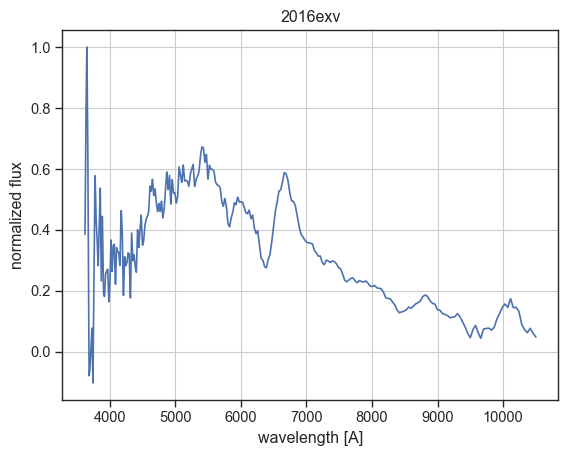

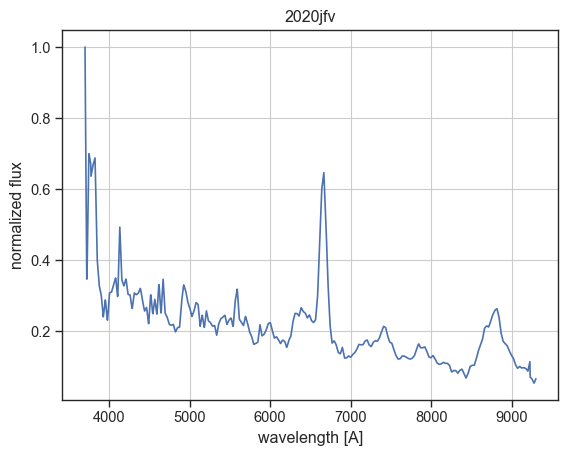

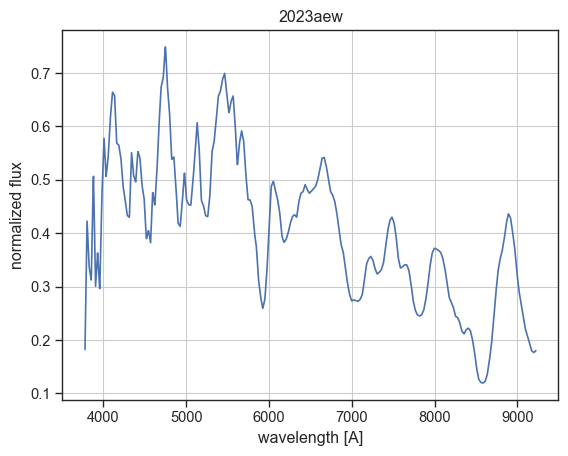

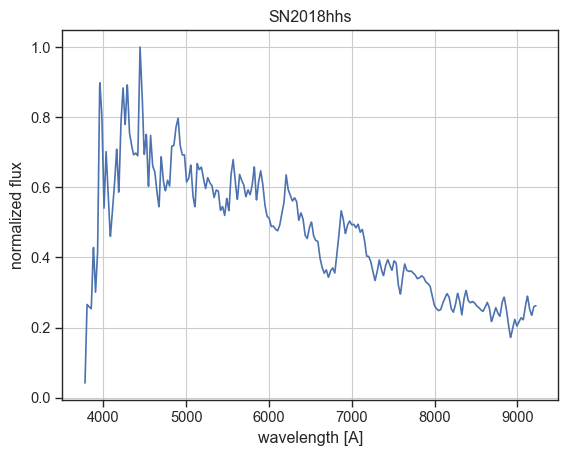

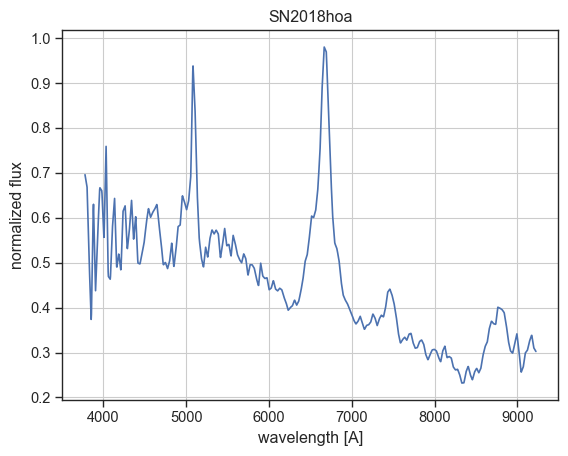

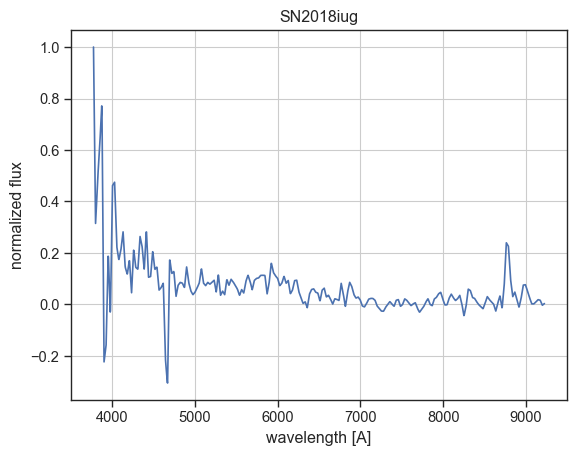

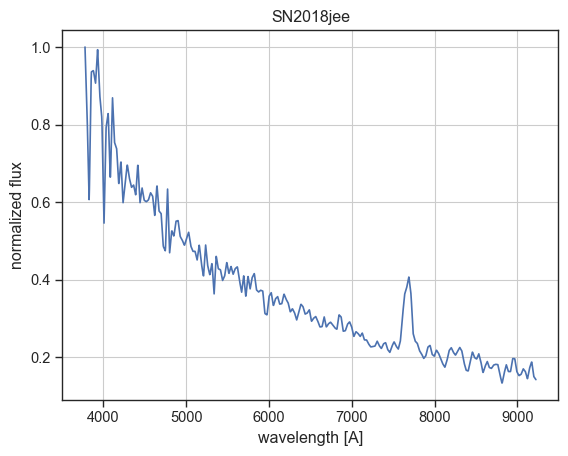

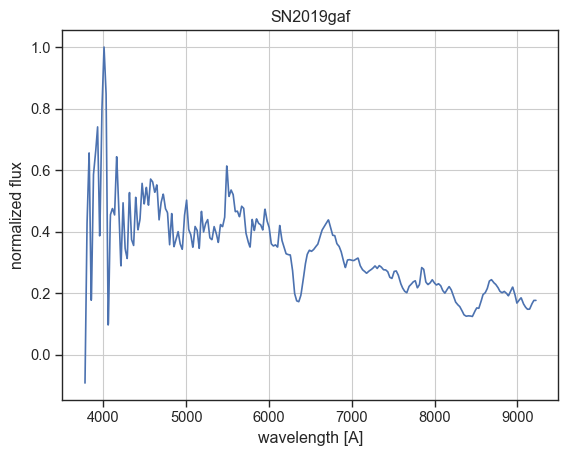

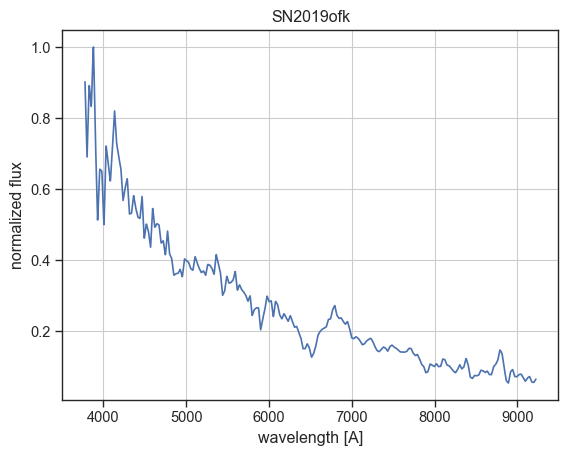

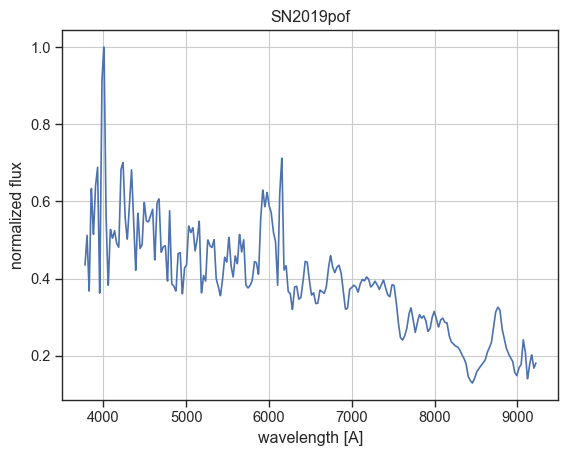

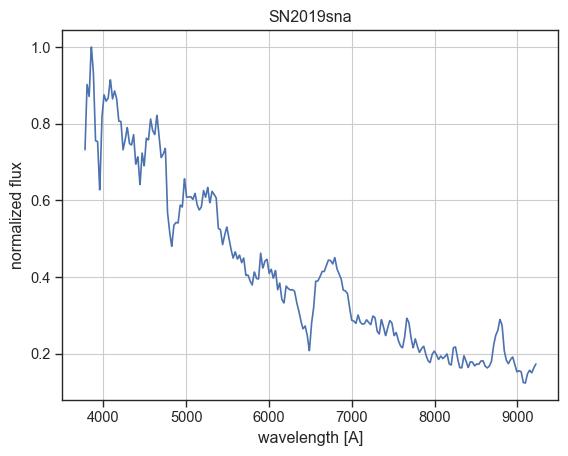

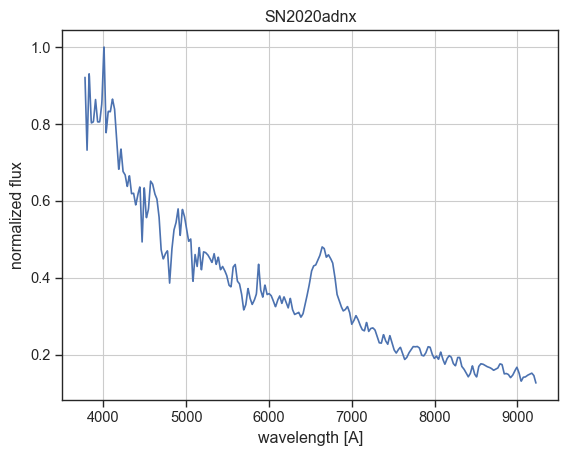

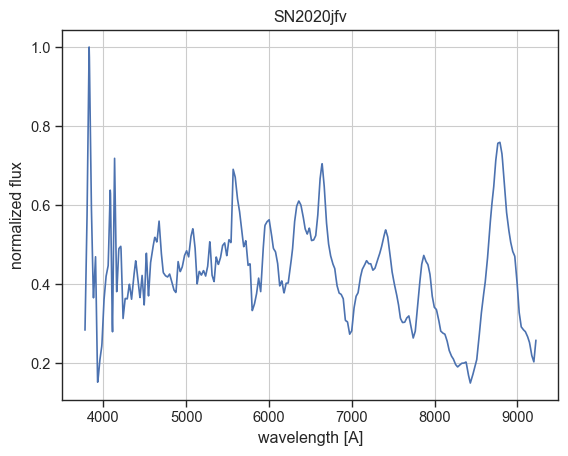

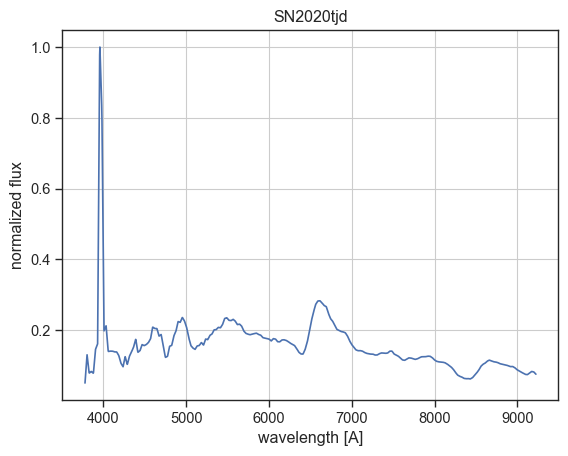

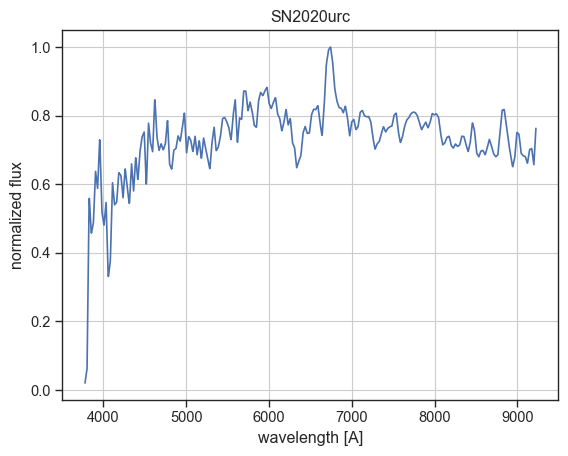

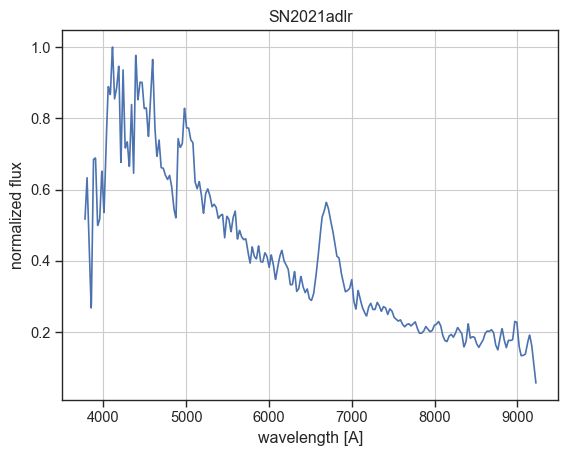

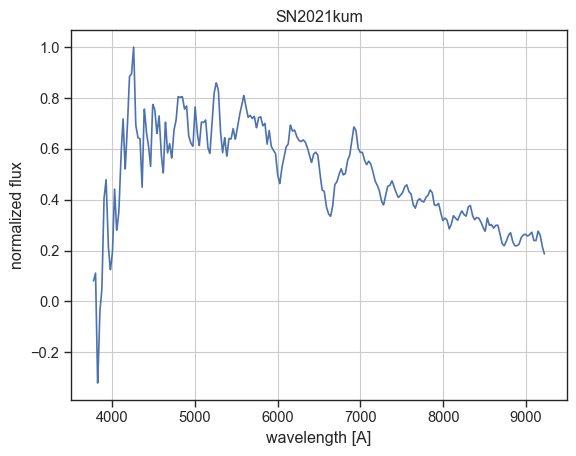

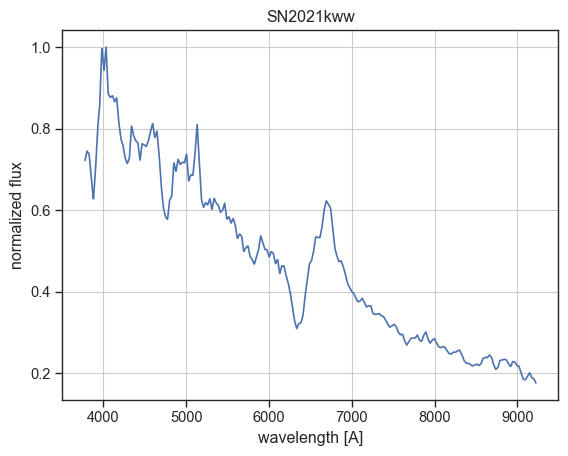

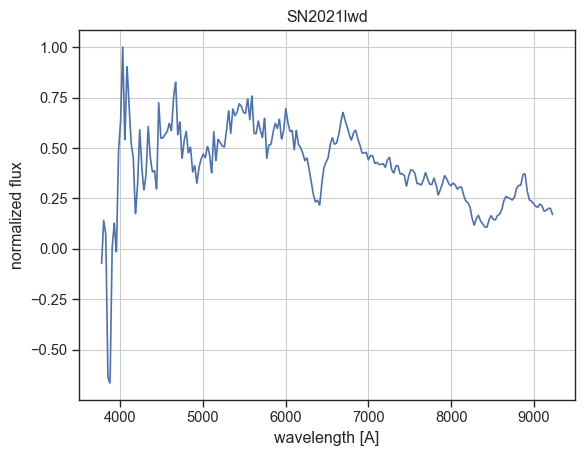

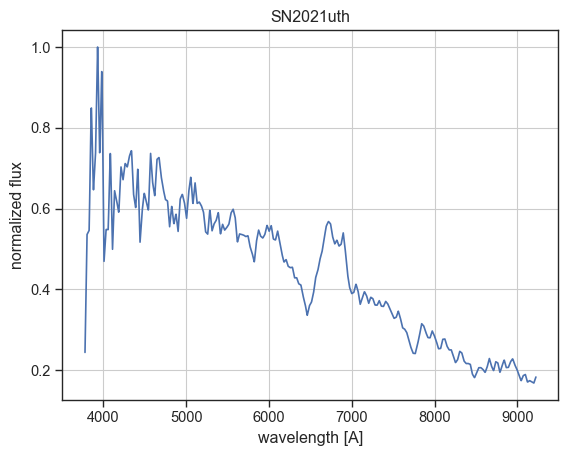

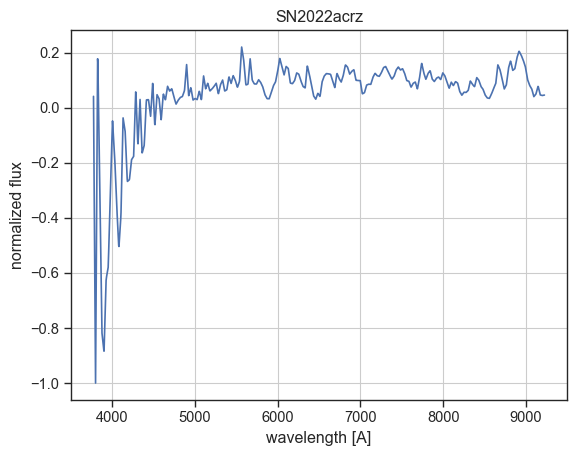

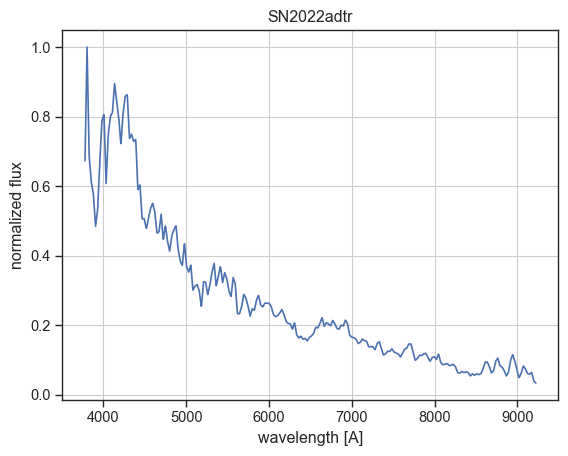

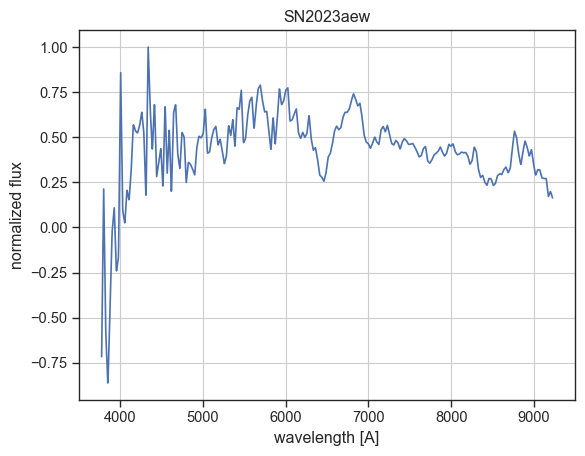

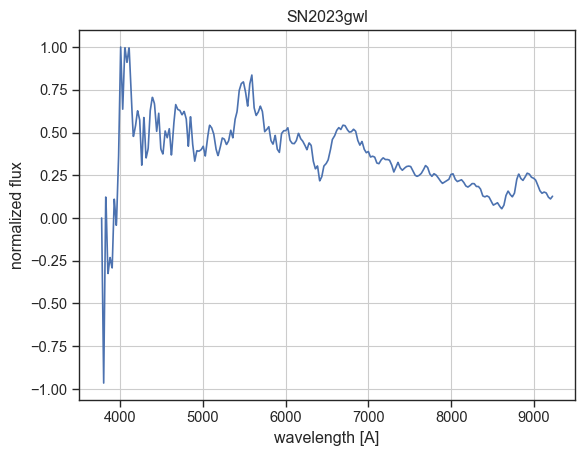

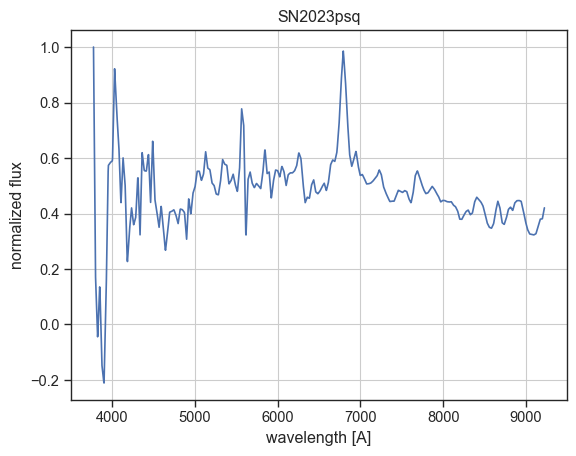

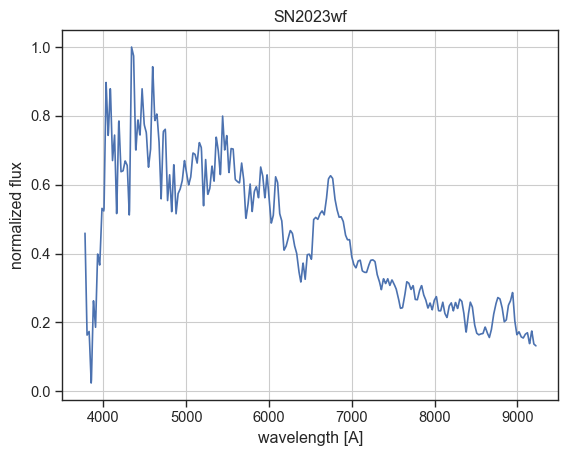

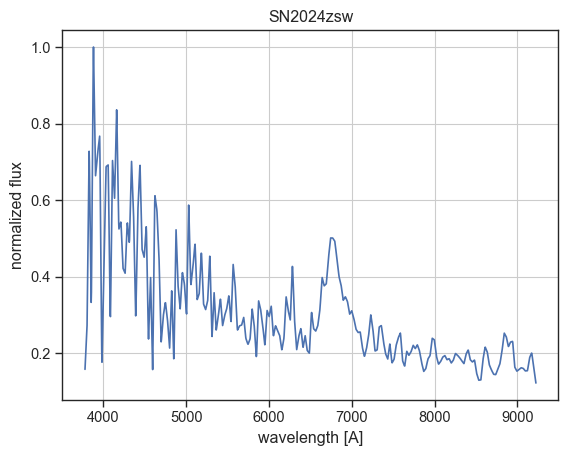

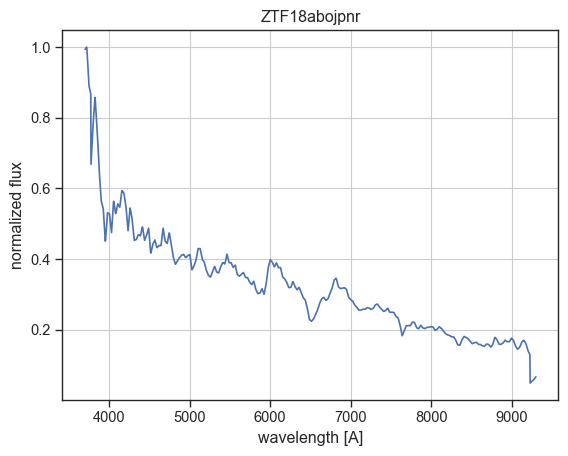

In [ ]:
for i in range(len(X)):
    plt.figure()
    plt.plot(wavelengths, X[i])
    plt.xlabel('wavelength [A]')
    plt.ylabel('normalized flux')
    plt.title(f'{obj_names[i]}')

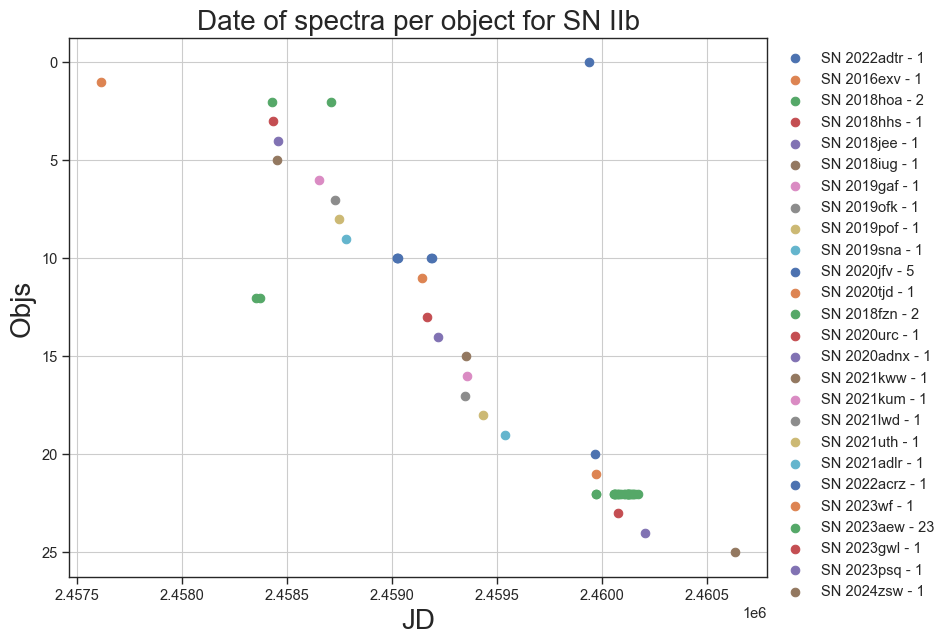

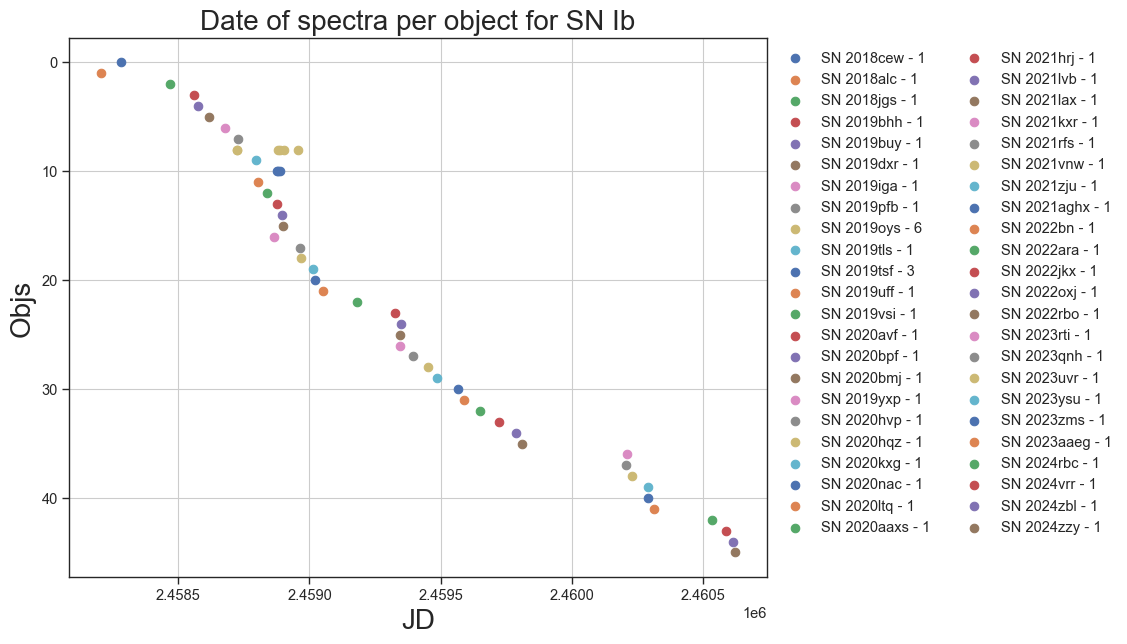

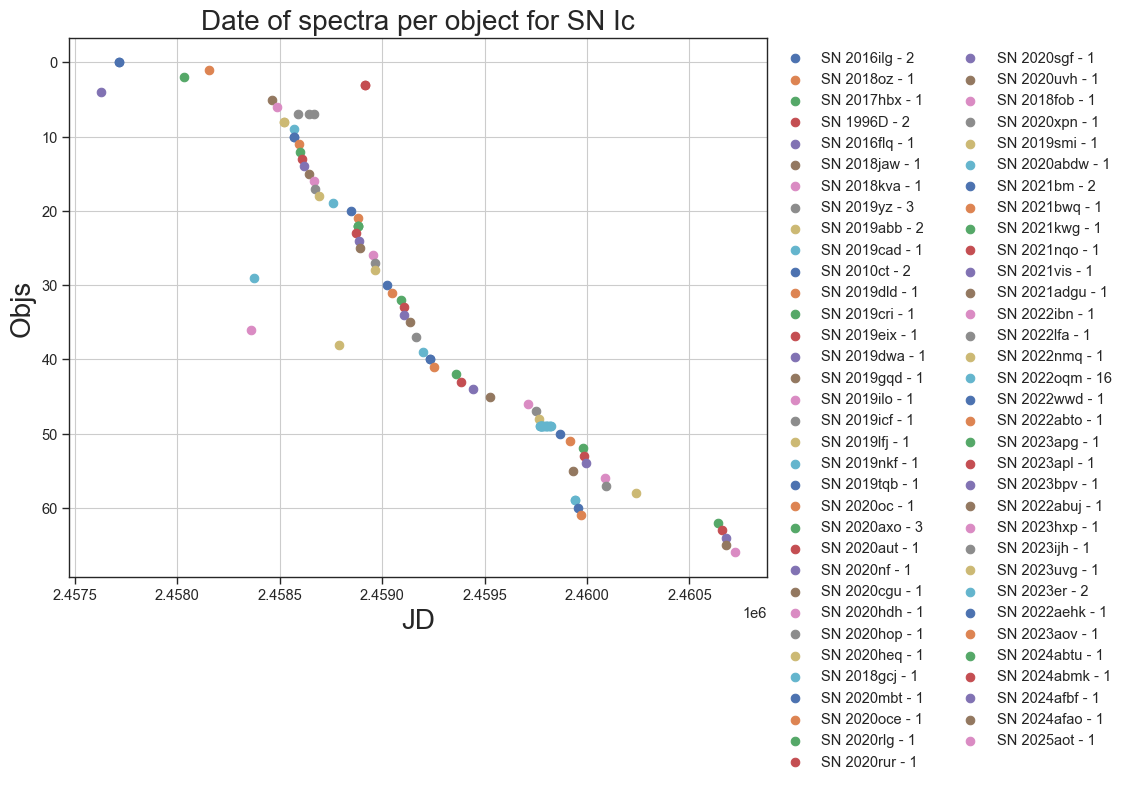

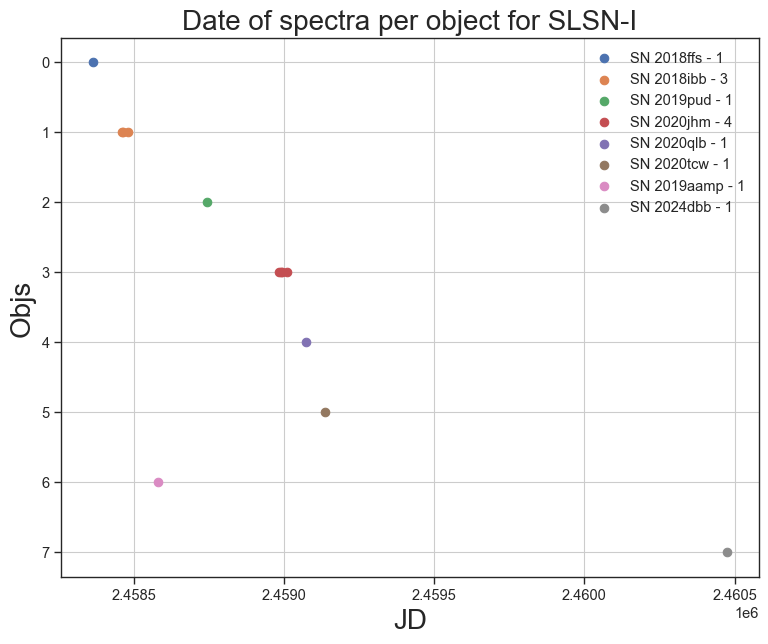

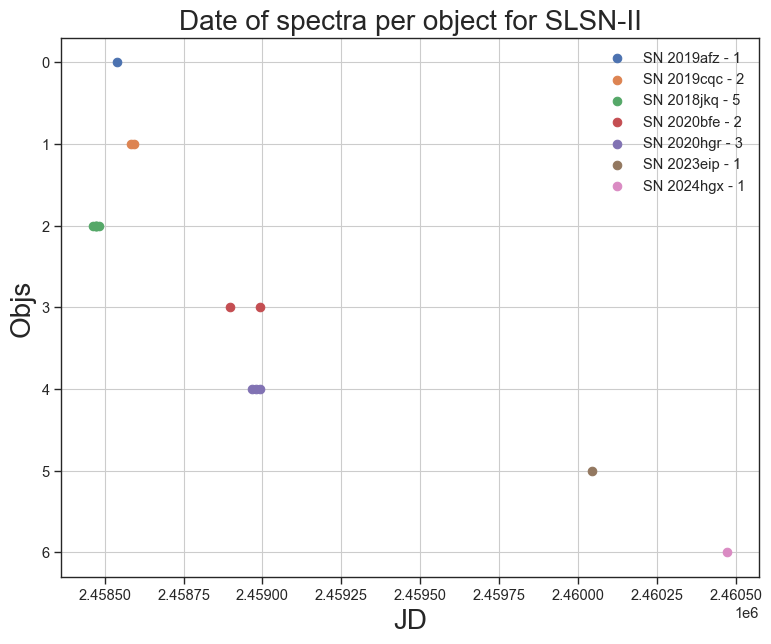

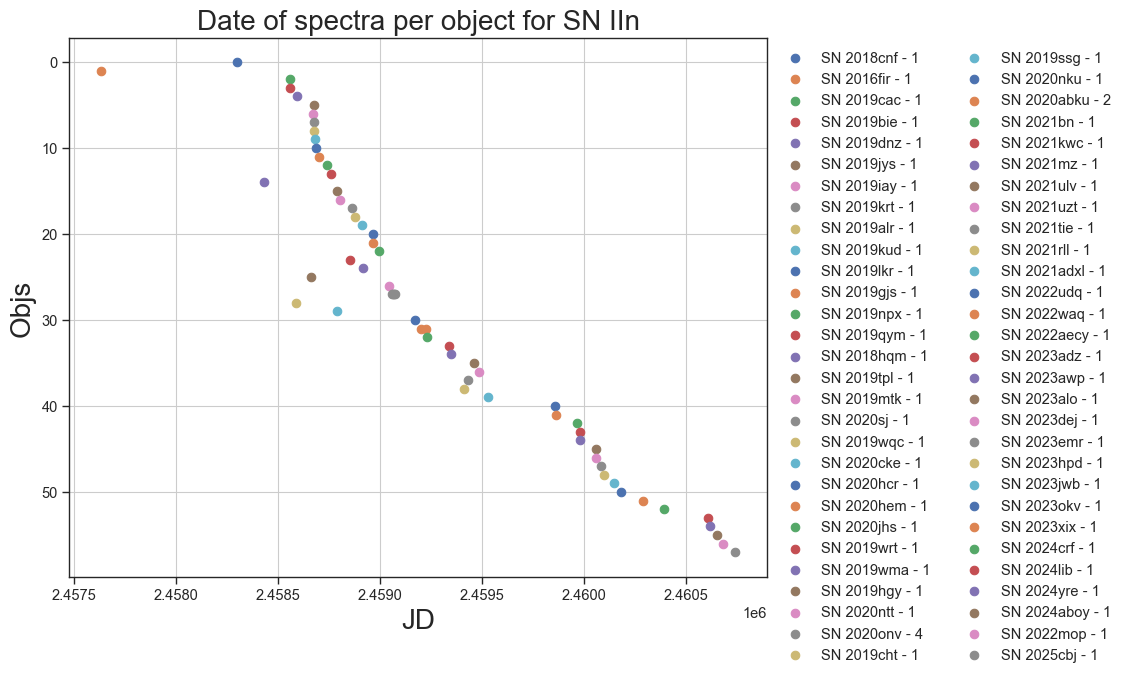

In [ ]:
types_str = ['SN IIb', 'SN Ib', 'SN Ic', 'SLSN-I', 'SLSN-II', 'SN IIn']
types_flags = [iib, ib, ic, slsni, slsnii, iin]

for i,types in enumerate(types_flags):
    objs = all_spec_meta.loc[types&p60&sedm,'IAU name'].unique().tolist() #list of IIb names

    plt.figure(figsize=(9,7))
    plt.xlabel('JD', fontsize=20)
    plt.ylabel('Objs', fontsize=20)
    plt.title(f'Date of spectra per object for {types_str[i]}', fontsize=20)

    for j in range(len(objs)):
        jds = all_spec_meta.loc[types&p60&sedm&(all_spec_meta['IAU name']==objs[j]), 'JD'].array #JD of spectra taken for individ obj
        plt.scatter(jds, [j]*len(jds), marker='.', s=150, label=f'{objs[j]} - {len(jds)}')

    if len(objs)>26:
        plt.legend(bbox_to_anchor=(1,1.0), frameon=False, ncol=2)
    else:
        plt.legend(bbox_to_anchor=(1,1.0), frameon=False, ncol=1)
    plt.gca().invert_yaxis()

    plt.savefig(f'./figures/num_spec_for_{types_str[i]}.png', bbox_inches='tight')

In [ ]:
#TODO: need to add in Phase (days) data to all spectra